In [1]:

import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)


In [2]:

class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./../data", 
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)


In [3]:

# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)
  
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)


In [4]:

# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]
    

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256
        
        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)
        
        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)
        
        # Convolution to 28x28 (1 feature map)
        return self.conv(x)


In [5]:

# TODO: GAN

class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()

        # random noise
        self.validation_z = torch.randn(6, self.hparams.latent_dim)

        # automatic optimization off
        self.automatic_optimization = False

    def forward(self, z):   
        return self.generator(z)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch

        opt_g, opt_d = self.optimizers()

        # sample noise
        z = torch.randn(real_imgs.shape[0], self.hparams.latent_dim, device=self.device)
        z = z.type_as(real_imgs)

        # train generator: maximize log(D(G(z)))
        opt_g.zero_grad()
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)
        g_loss = self.adversarial_loss(y_hat, torch.ones_like(y_hat))
        self.manual_backward(g_loss)
        opt_g.step()
        
        # train discriminator: maximize log(D(x)) + log(1 - D(G(z)))
        opt_d.zero_grad()
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        # true labeled as fake
        y_hat_fake = self.discriminator(self(z).detach())
        y_fake = torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = (real_loss + fake_loss) / 2
        self.manual_backward(d_loss)
        opt_d.step()

        # 로그 저장
        self.log("g_loss", g_loss, prog_bar=True)
        self.log("d_loss", d_loss, prog_bar=True)
 

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d]
    
    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()

        print('epoch ', self.current_epoch)
        fig = plt.figure()
        for i in range(len(sample_imgs)):
            plt.subplot(2, 3, i+1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i,0,:,:], cmap='gray', interpolation='none')
            plt.xticks([])
            plt.yticks([])
            plt.axis('off')
        plt.show()
    
    def on_train_epoch_end(self):
        self.plot_imgs()


In [6]:
dm = MNISTDataModule()
model = GAN()

epoch  0


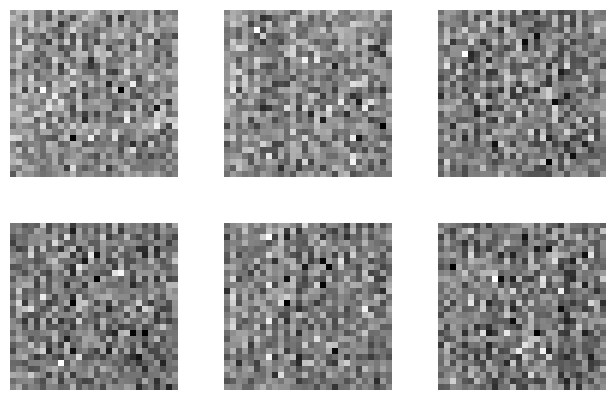

In [7]:
model.plot_imgs()   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 430/430 [00:06<00:00, 69.02it/s, v_num=6, g_loss=1.910, d_loss=0.449] epoch  0


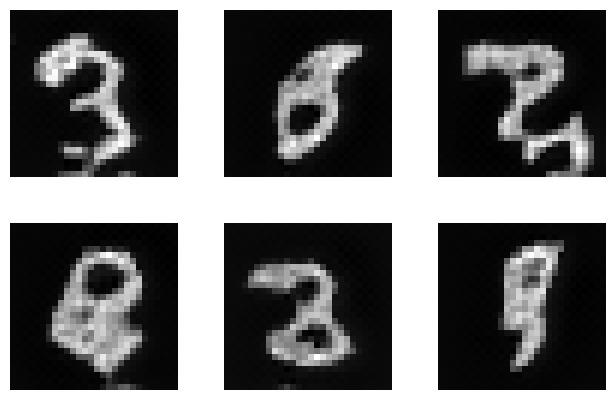

Epoch 1: 100%|██████████| 430/430 [00:05<00:00, 78.38it/s, v_num=6, g_loss=1.650, d_loss=0.383]epoch  1


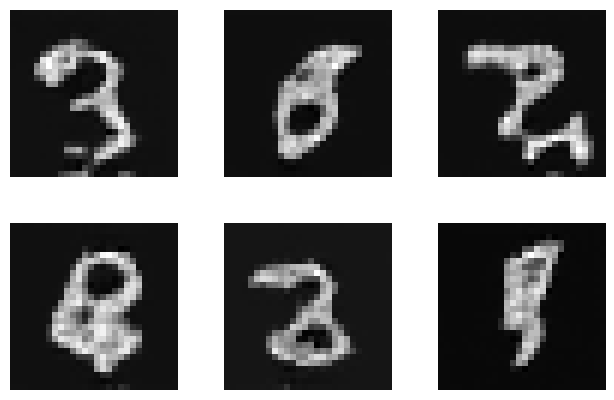

Epoch 2: 100%|██████████| 430/430 [00:05<00:00, 77.79it/s, v_num=6, g_loss=1.660, d_loss=0.397]epoch  2


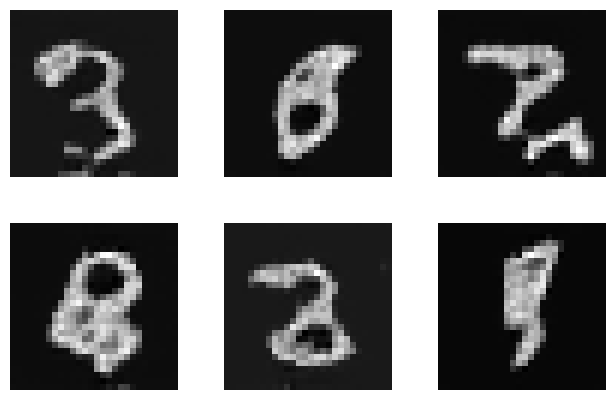

Epoch 3: 100%|██████████| 430/430 [00:05<00:00, 76.06it/s, v_num=6, g_loss=1.570, d_loss=0.426]epoch  3


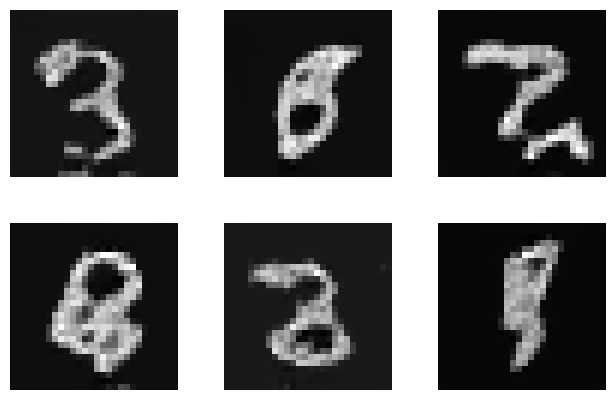

Epoch 4: 100%|██████████| 430/430 [00:05<00:00, 71.68it/s, v_num=6, g_loss=1.560, d_loss=0.359]epoch  4


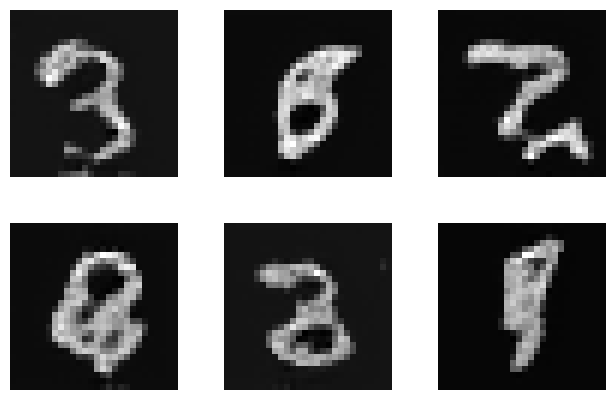

Epoch 5: 100%|██████████| 430/430 [00:05<00:00, 72.25it/s, v_num=6, g_loss=1.300, d_loss=0.480]epoch  5


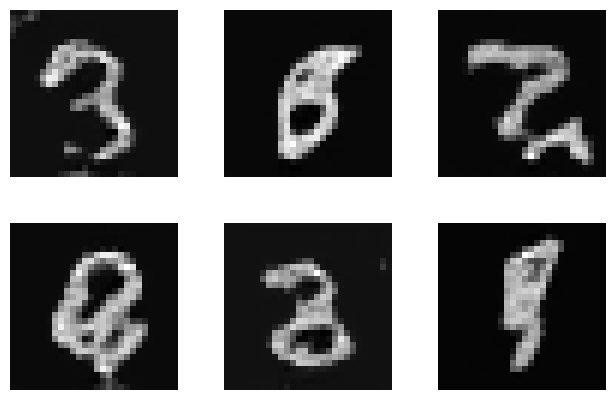

Epoch 6: 100%|██████████| 430/430 [00:05<00:00, 78.07it/s, v_num=6, g_loss=1.410, d_loss=0.478]epoch  6


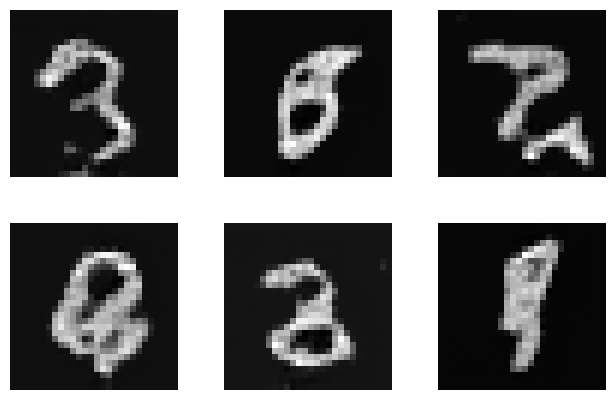

Epoch 7: 100%|██████████| 430/430 [00:05<00:00, 80.11it/s, v_num=6, g_loss=1.210, d_loss=0.422]epoch  7


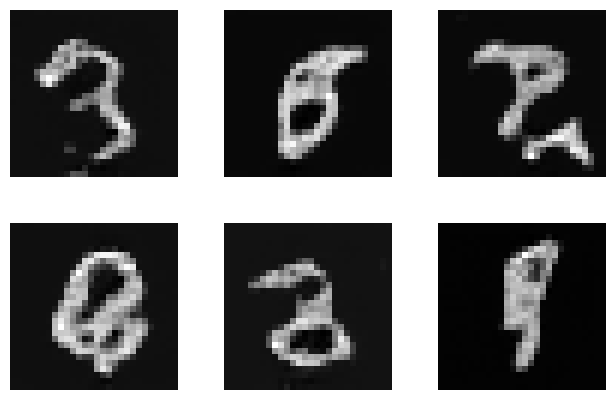

Epoch 8: 100%|██████████| 430/430 [00:05<00:00, 80.26it/s, v_num=6, g_loss=1.230, d_loss=0.487]epoch  8


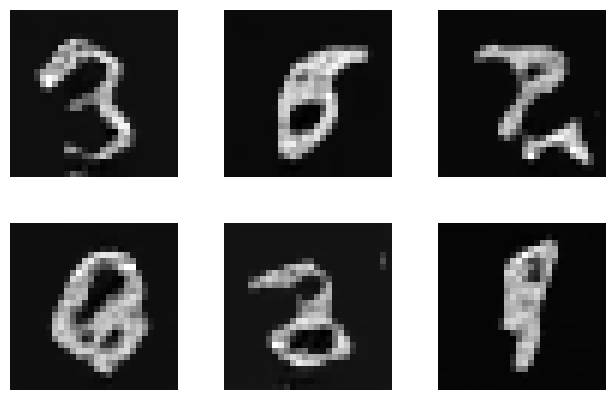

Epoch 9: 100%|██████████| 430/430 [00:05<00:00, 84.05it/s, v_num=6, g_loss=1.520, d_loss=0.362]epoch  9


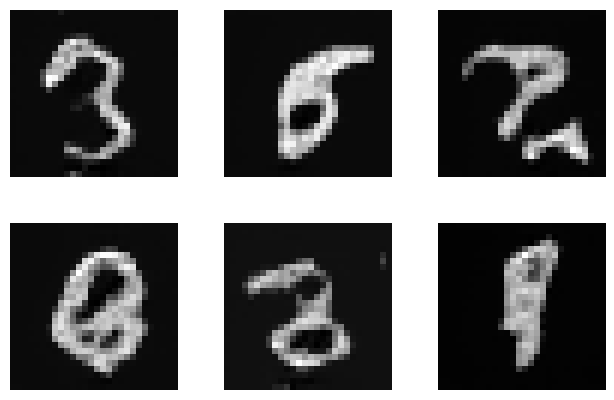

Epoch 10: 100%|██████████| 430/430 [00:06<00:00, 69.58it/s, v_num=6, g_loss=1.250, d_loss=0.390]epoch  10


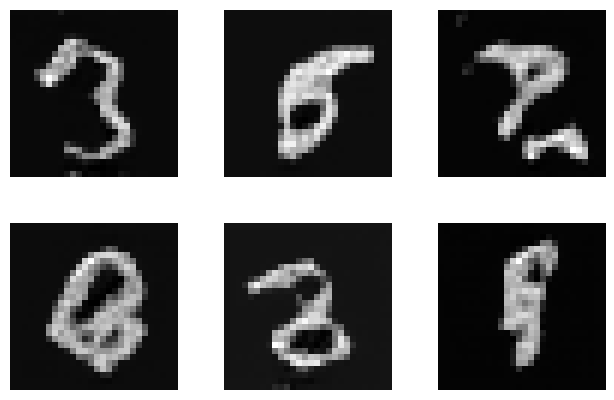

Epoch 11: 100%|██████████| 430/430 [00:05<00:00, 75.43it/s, v_num=6, g_loss=1.140, d_loss=0.511]epoch  11


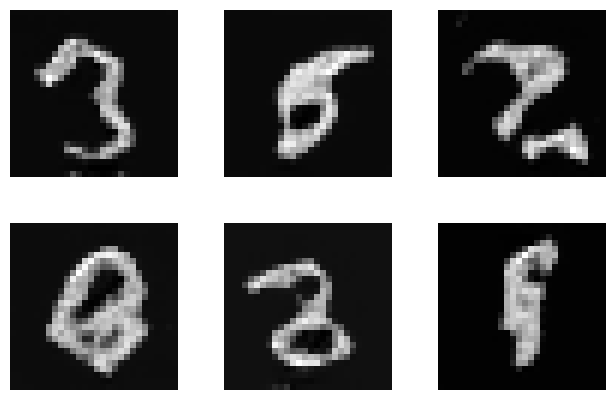

Epoch 12: 100%|██████████| 430/430 [00:05<00:00, 77.68it/s, v_num=6, g_loss=1.230, d_loss=0.471]epoch  12


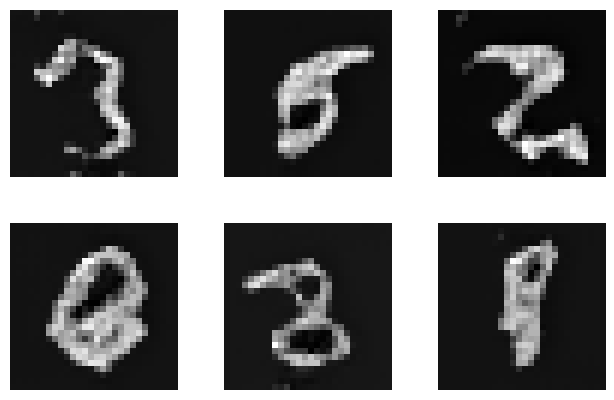

Epoch 13: 100%|██████████| 430/430 [00:05<00:00, 78.09it/s, v_num=6, g_loss=1.500, d_loss=0.360]epoch  13


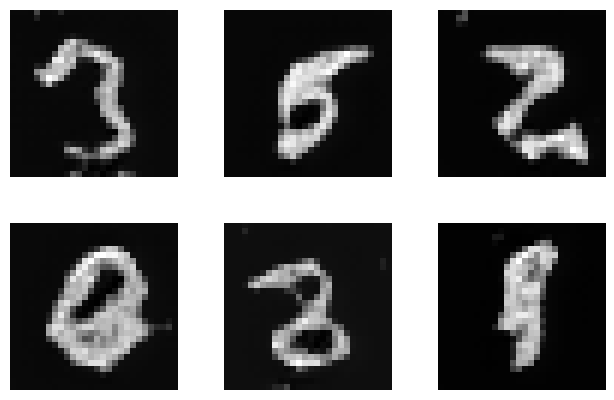

Epoch 14: 100%|██████████| 430/430 [00:05<00:00, 80.40it/s, v_num=6, g_loss=1.240, d_loss=0.522]epoch  14


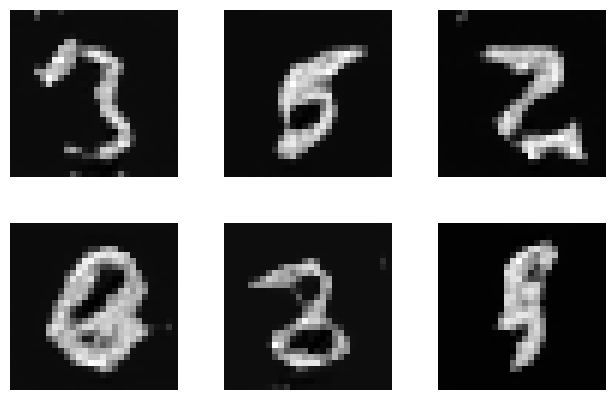

Epoch 15: 100%|██████████| 430/430 [00:05<00:00, 72.37it/s, v_num=6, g_loss=1.130, d_loss=0.492]epoch  15


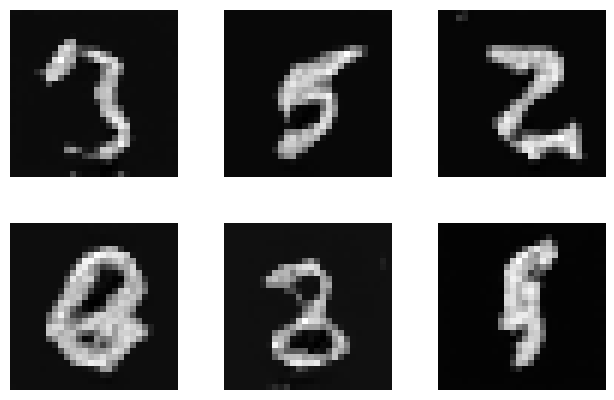

Epoch 16: 100%|██████████| 430/430 [00:05<00:00, 71.72it/s, v_num=6, g_loss=1.220, d_loss=0.481]epoch  16


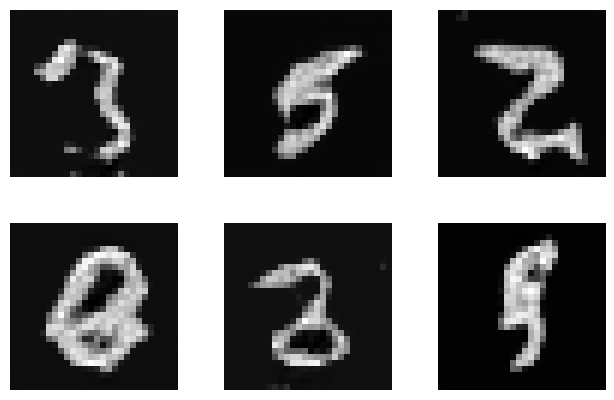

Epoch 17: 100%|██████████| 430/430 [00:05<00:00, 77.40it/s, v_num=6, g_loss=1.230, d_loss=0.573]epoch  17


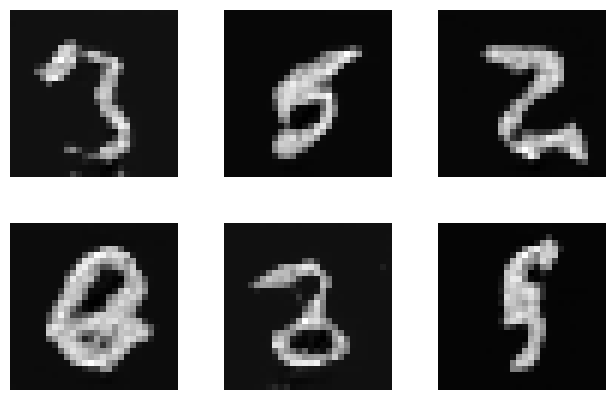

Epoch 18: 100%|██████████| 430/430 [00:05<00:00, 77.85it/s, v_num=6, g_loss=1.320, d_loss=0.472]epoch  18


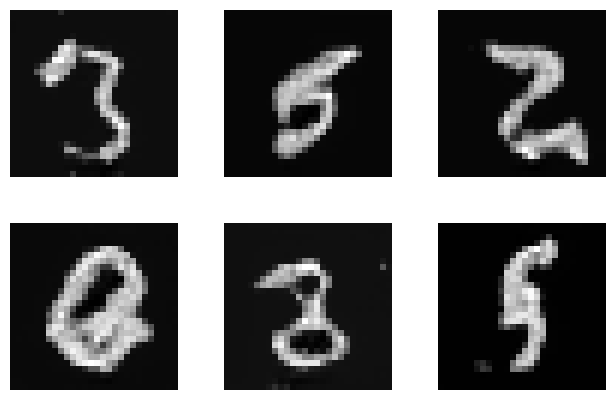

Epoch 19: 100%|██████████| 430/430 [00:05<00:00, 80.84it/s, v_num=6, g_loss=1.180, d_loss=0.528]epoch  19


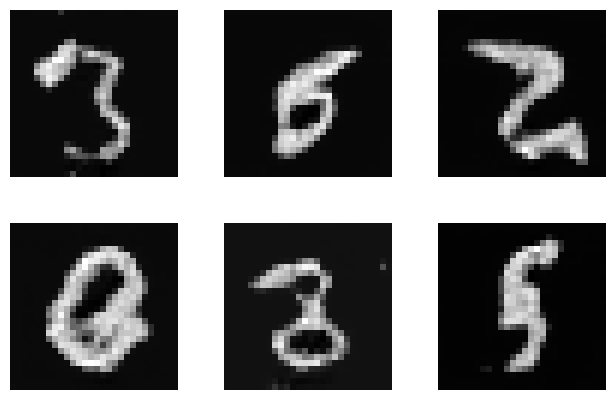

Epoch 20: 100%|██████████| 430/430 [00:05<00:00, 76.66it/s, v_num=6, g_loss=1.320, d_loss=0.555]epoch  20


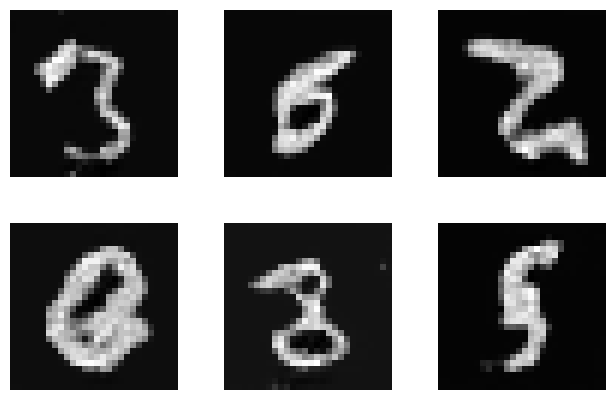

Epoch 21: 100%|██████████| 430/430 [00:05<00:00, 76.88it/s, v_num=6, g_loss=1.370, d_loss=0.471]epoch  21


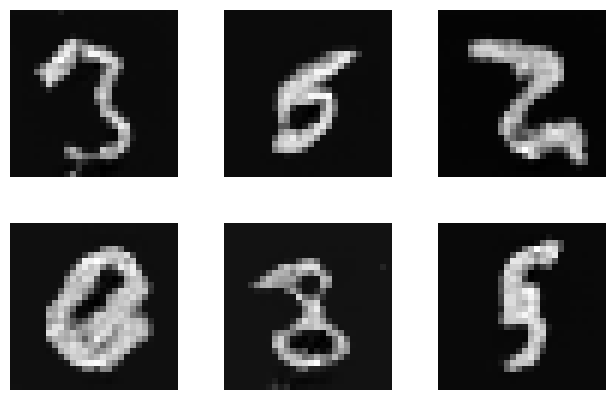

Epoch 22: 100%|██████████| 430/430 [00:05<00:00, 79.31it/s, v_num=6, g_loss=1.120, d_loss=0.433]epoch  22


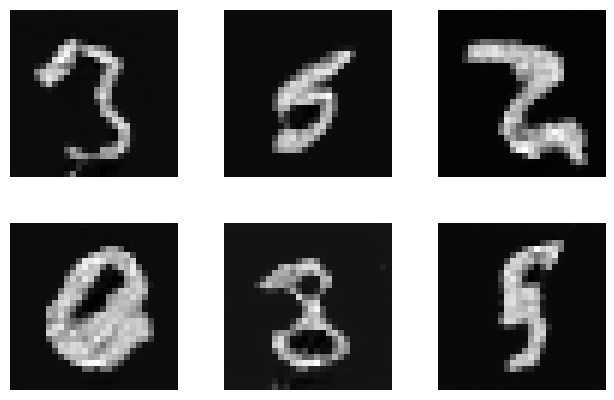

Epoch 23: 100%|██████████| 430/430 [00:05<00:00, 80.37it/s, v_num=6, g_loss=1.140, d_loss=0.524]epoch  23


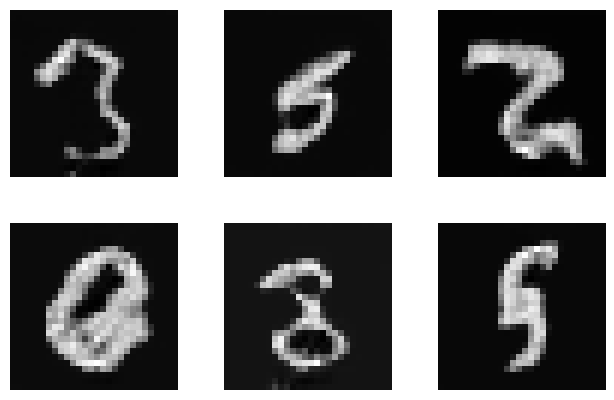

Epoch 24: 100%|██████████| 430/430 [00:05<00:00, 80.59it/s, v_num=6, g_loss=1.170, d_loss=0.491]epoch  24


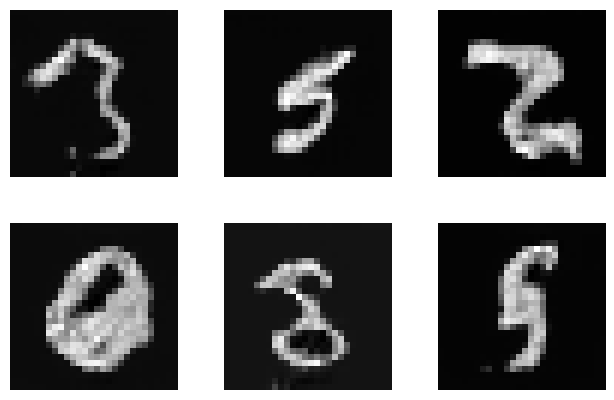

Epoch 25: 100%|██████████| 430/430 [00:05<00:00, 77.50it/s, v_num=6, g_loss=1.020, d_loss=0.448]epoch  25


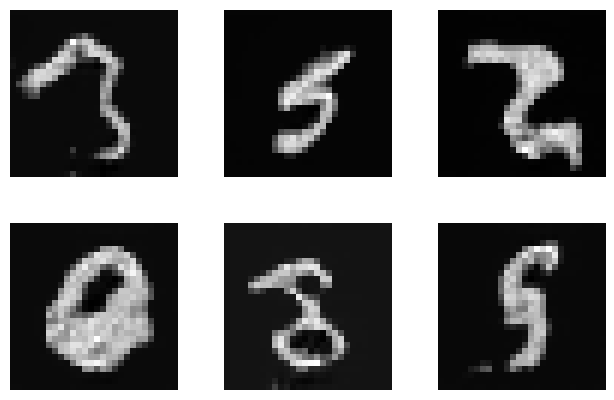

Epoch 26: 100%|██████████| 430/430 [00:05<00:00, 76.73it/s, v_num=6, g_loss=1.290, d_loss=0.534]epoch  26


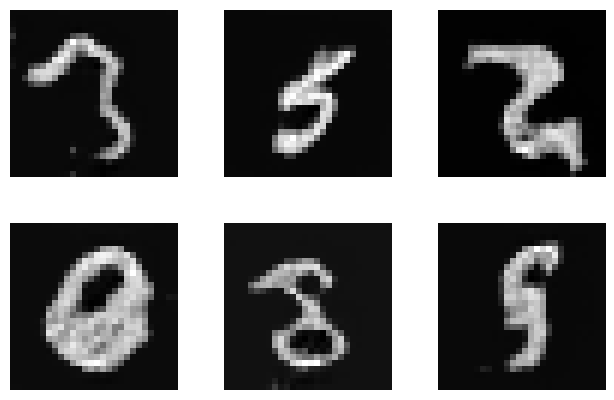

Epoch 27: 100%|██████████| 430/430 [00:05<00:00, 79.21it/s, v_num=6, g_loss=1.210, d_loss=0.508]epoch  27


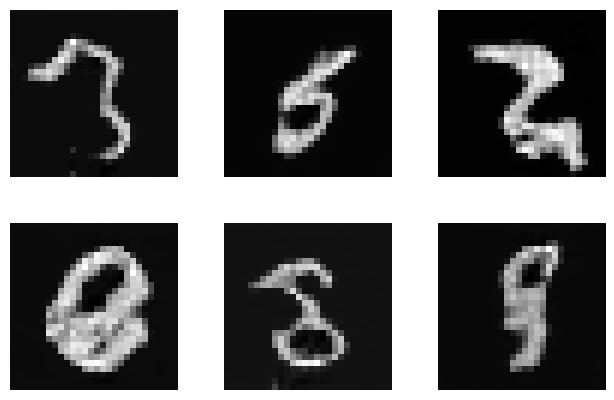

Epoch 28: 100%|██████████| 430/430 [00:05<00:00, 76.66it/s, v_num=6, g_loss=1.380, d_loss=0.446]epoch  28


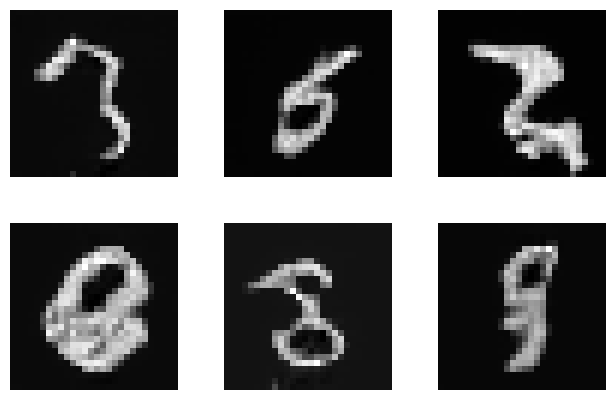

Epoch 29: 100%|██████████| 430/430 [00:05<00:00, 76.34it/s, v_num=6, g_loss=1.310, d_loss=0.446]epoch  29


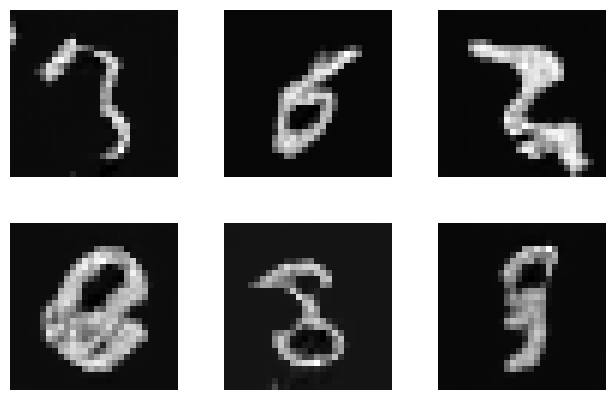

Epoch 30: 100%|██████████| 430/430 [00:05<00:00, 74.39it/s, v_num=6, g_loss=1.050, d_loss=0.609]epoch  30


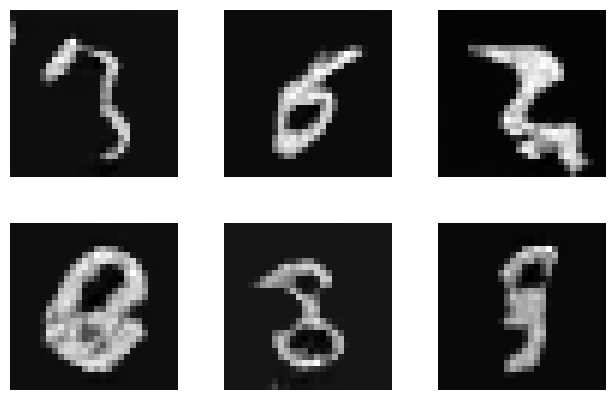

Epoch 31: 100%|██████████| 430/430 [00:05<00:00, 73.81it/s, v_num=6, g_loss=0.971, d_loss=0.536]epoch  31


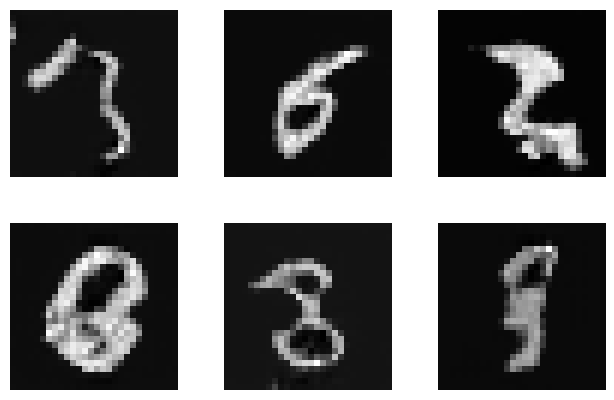

Epoch 32: 100%|██████████| 430/430 [00:05<00:00, 74.20it/s, v_num=6, g_loss=0.995, d_loss=0.528]epoch  32


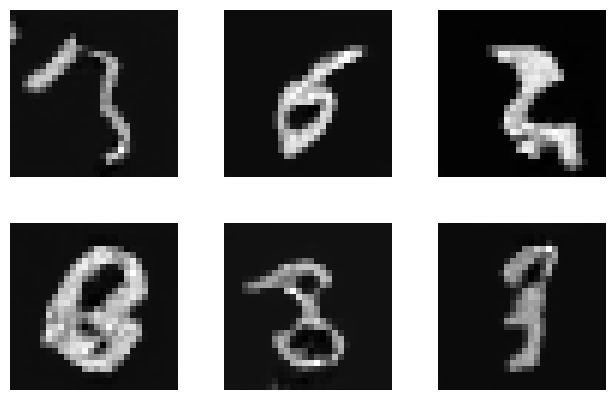

Epoch 33: 100%|██████████| 430/430 [00:05<00:00, 76.49it/s, v_num=6, g_loss=0.967, d_loss=0.636]epoch  33


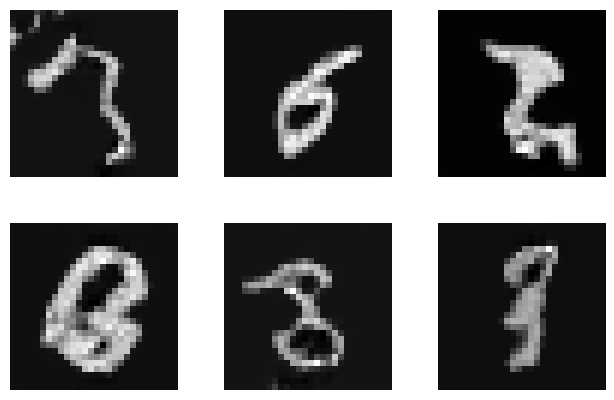

Epoch 34: 100%|██████████| 430/430 [00:05<00:00, 76.08it/s, v_num=6, g_loss=1.030, d_loss=0.570]epoch  34


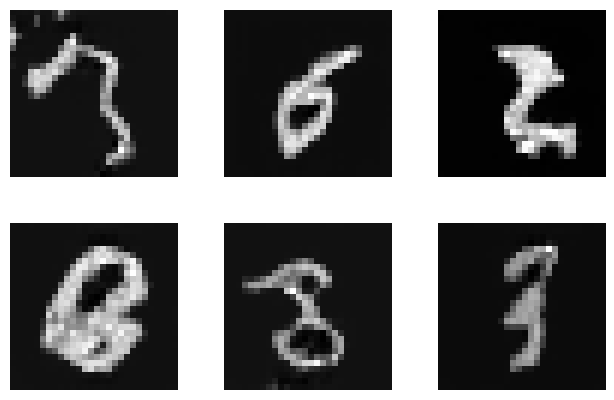

Epoch 35: 100%|██████████| 430/430 [00:06<00:00, 70.31it/s, v_num=6, g_loss=1.010, d_loss=0.526]epoch  35


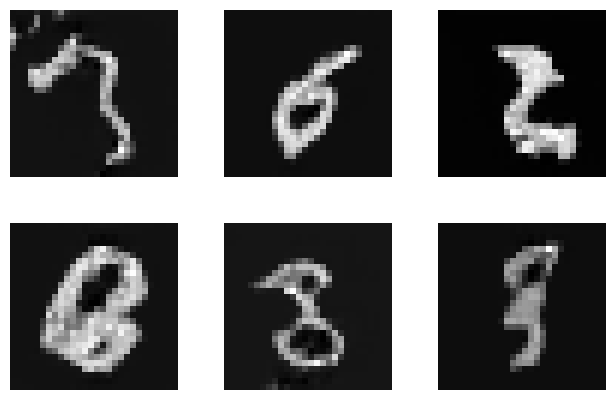

Epoch 36: 100%|██████████| 430/430 [00:06<00:00, 68.68it/s, v_num=6, g_loss=0.958, d_loss=0.581]epoch  36


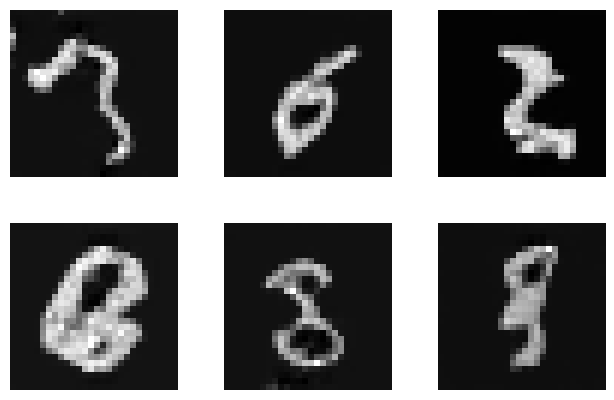

Epoch 37: 100%|██████████| 430/430 [00:05<00:00, 75.30it/s, v_num=6, g_loss=0.957, d_loss=0.518]epoch  37


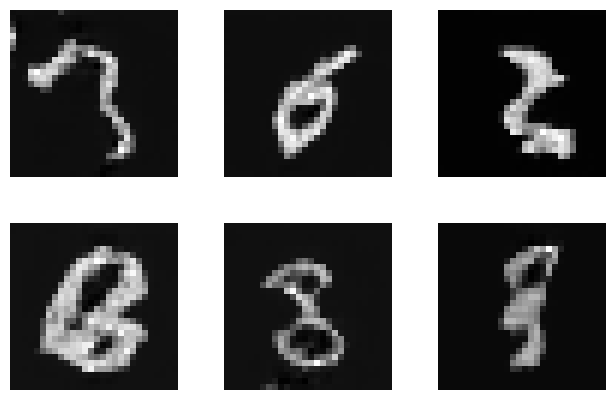

Epoch 38: 100%|██████████| 430/430 [00:05<00:00, 75.46it/s, v_num=6, g_loss=1.290, d_loss=0.461]epoch  38


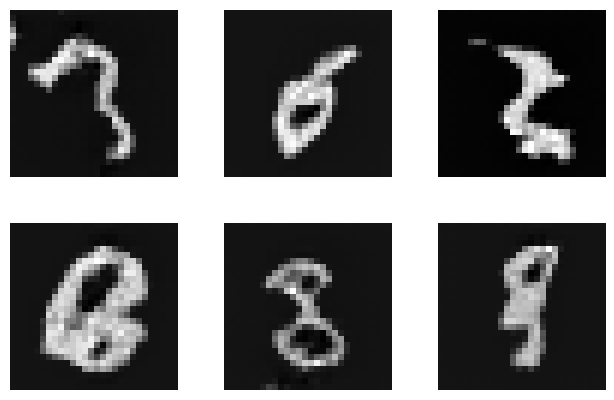

Epoch 39: 100%|██████████| 430/430 [00:05<00:00, 76.30it/s, v_num=6, g_loss=0.988, d_loss=0.588]epoch  39


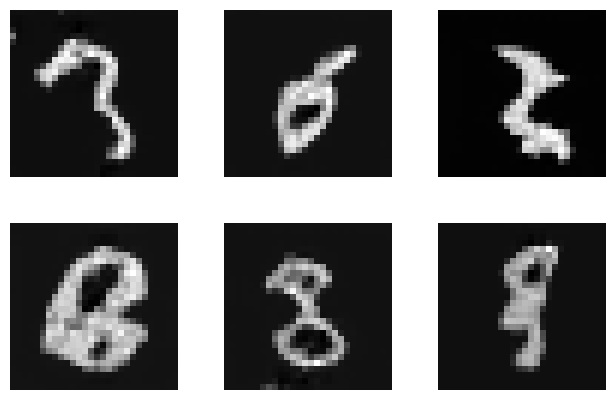

Epoch 40: 100%|██████████| 430/430 [00:05<00:00, 75.85it/s, v_num=6, g_loss=0.926, d_loss=0.560]epoch  40


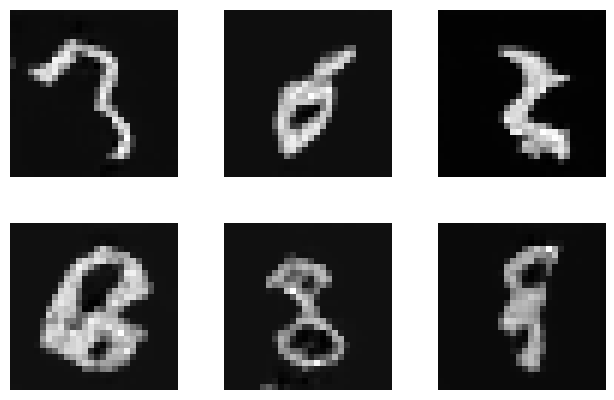

Epoch 41: 100%|██████████| 430/430 [00:05<00:00, 74.18it/s, v_num=6, g_loss=1.000, d_loss=0.513]epoch  41


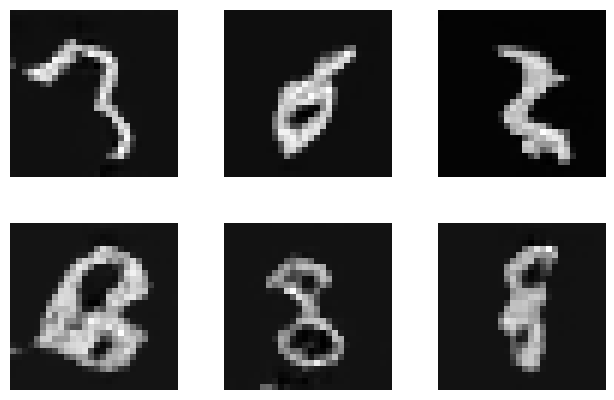

Epoch 42: 100%|██████████| 430/430 [00:05<00:00, 73.45it/s, v_num=6, g_loss=0.987, d_loss=0.603]epoch  42


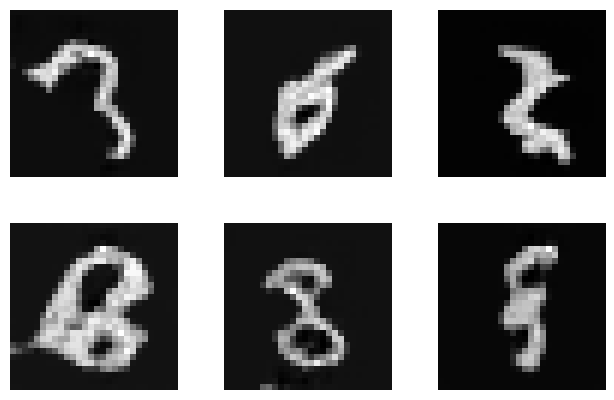

Epoch 43: 100%|██████████| 430/430 [00:05<00:00, 75.27it/s, v_num=6, g_loss=0.985, d_loss=0.609]epoch  43


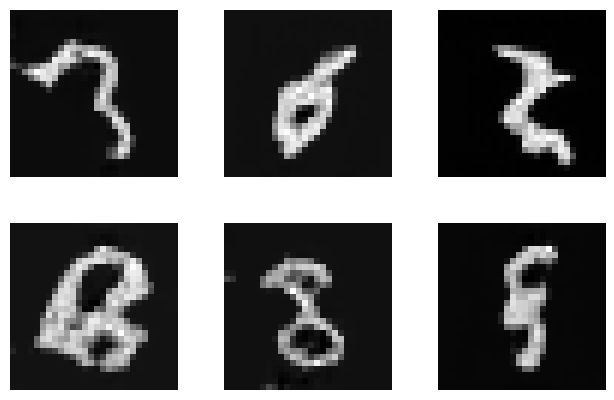

Epoch 44: 100%|██████████| 430/430 [00:05<00:00, 77.99it/s, v_num=6, g_loss=1.100, d_loss=0.535]epoch  44


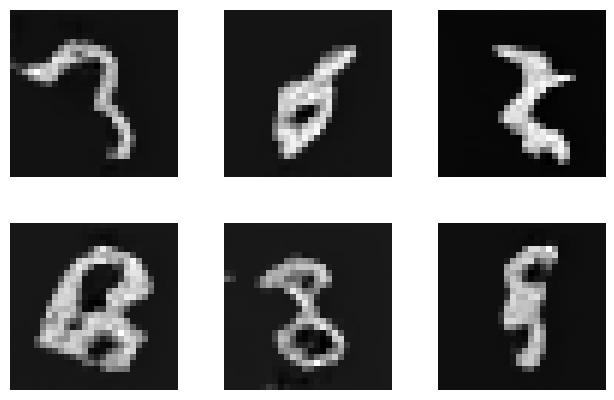

Epoch 45: 100%|██████████| 430/430 [00:05<00:00, 77.21it/s, v_num=6, g_loss=1.160, d_loss=0.601]epoch  45


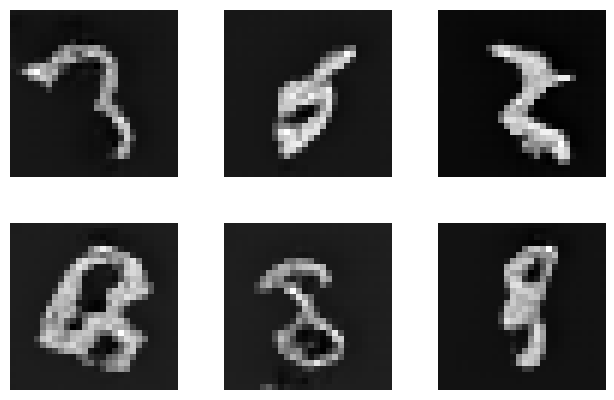

Epoch 46: 100%|██████████| 430/430 [00:05<00:00, 72.57it/s, v_num=6, g_loss=1.010, d_loss=0.533]epoch  46


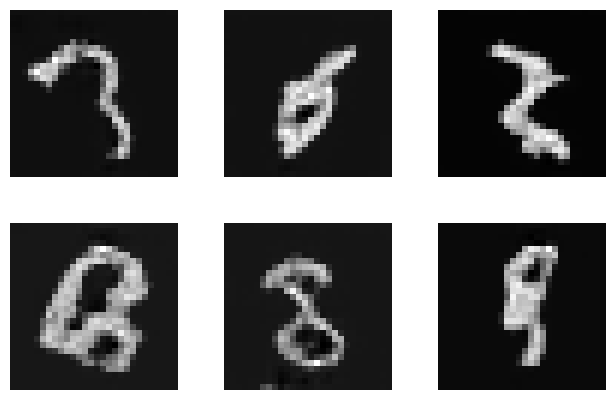

Epoch 47: 100%|██████████| 430/430 [00:05<00:00, 76.41it/s, v_num=6, g_loss=0.971, d_loss=0.564]epoch  47


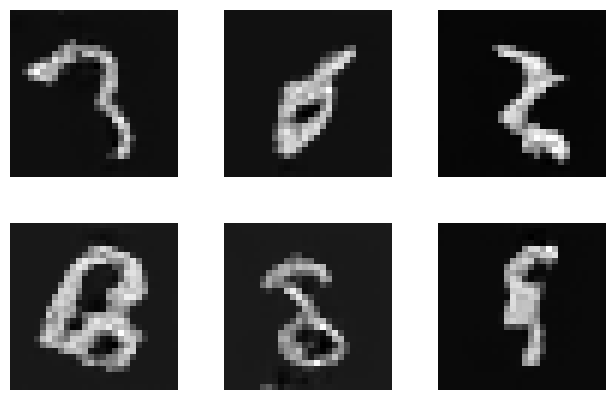

Epoch 48: 100%|██████████| 430/430 [00:05<00:00, 76.21it/s, v_num=6, g_loss=0.942, d_loss=0.623]epoch  48


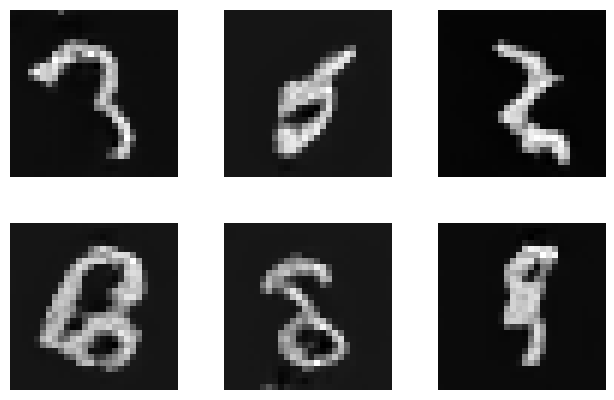

Epoch 49: 100%|██████████| 430/430 [00:05<00:00, 75.52it/s, v_num=6, g_loss=0.940, d_loss=0.602]epoch  49


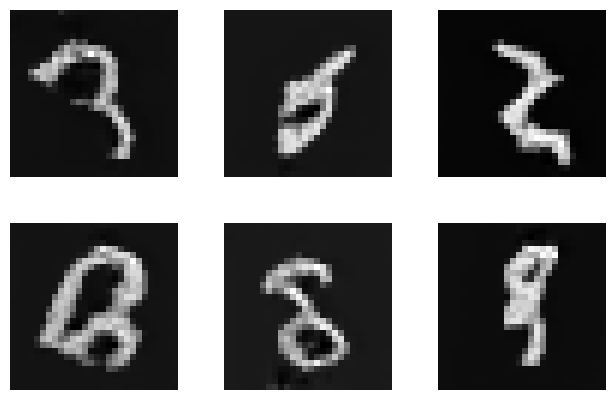

Epoch 50: 100%|██████████| 430/430 [00:05<00:00, 75.38it/s, v_num=6, g_loss=0.940, d_loss=0.599]epoch  50


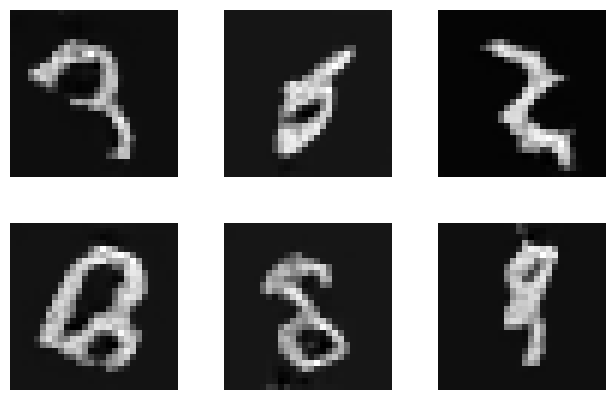

Epoch 51: 100%|██████████| 430/430 [00:06<00:00, 71.54it/s, v_num=6, g_loss=0.944, d_loss=0.511]epoch  51


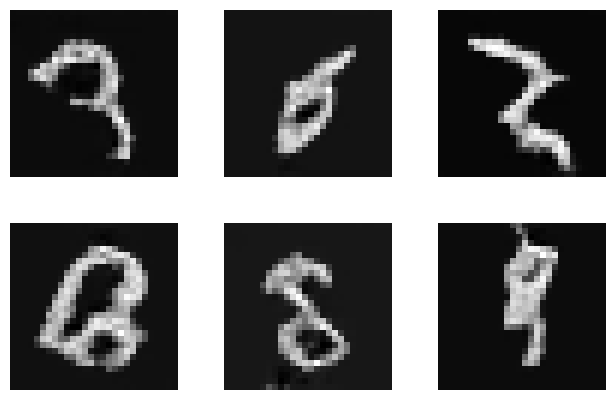

Epoch 52: 100%|██████████| 430/430 [00:05<00:00, 75.47it/s, v_num=6, g_loss=0.962, d_loss=0.494]epoch  52


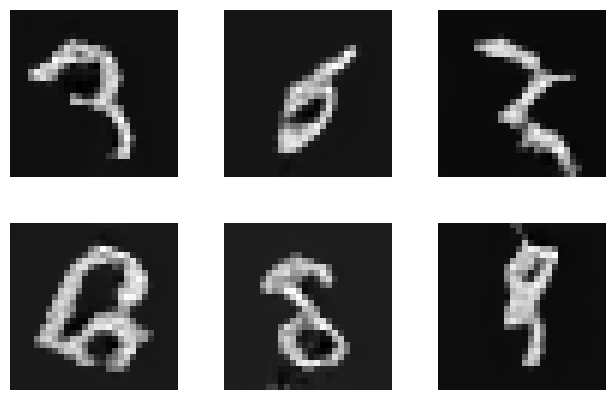

Epoch 53: 100%|██████████| 430/430 [00:05<00:00, 75.00it/s, v_num=6, g_loss=1.080, d_loss=0.567]epoch  53


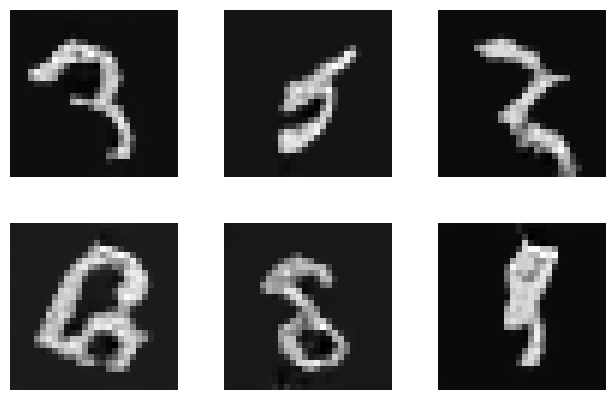

Epoch 54: 100%|██████████| 430/430 [00:05<00:00, 74.87it/s, v_num=6, g_loss=0.885, d_loss=0.592]epoch  54


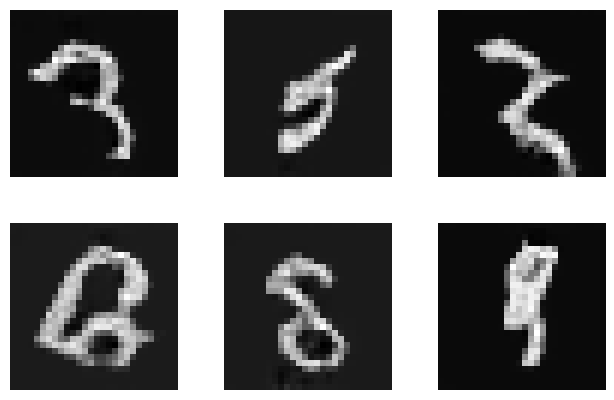

Epoch 55: 100%|██████████| 430/430 [00:05<00:00, 77.48it/s, v_num=6, g_loss=0.946, d_loss=0.619]epoch  55


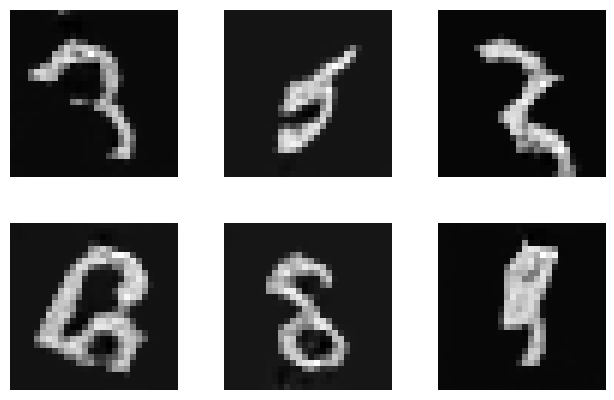

Epoch 56: 100%|██████████| 430/430 [00:05<00:00, 73.94it/s, v_num=6, g_loss=0.972, d_loss=0.552]epoch  56


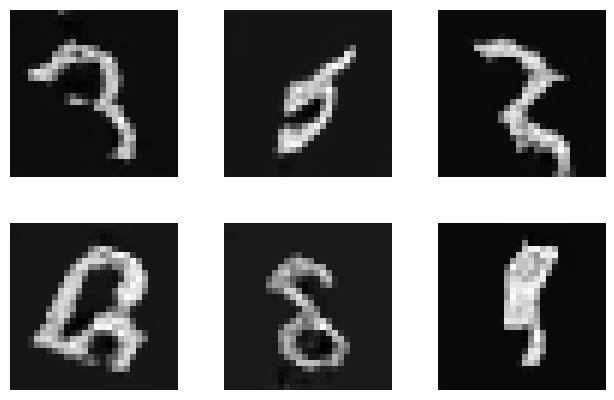

Epoch 57: 100%|██████████| 430/430 [00:05<00:00, 75.88it/s, v_num=6, g_loss=1.320, d_loss=0.585]epoch  57


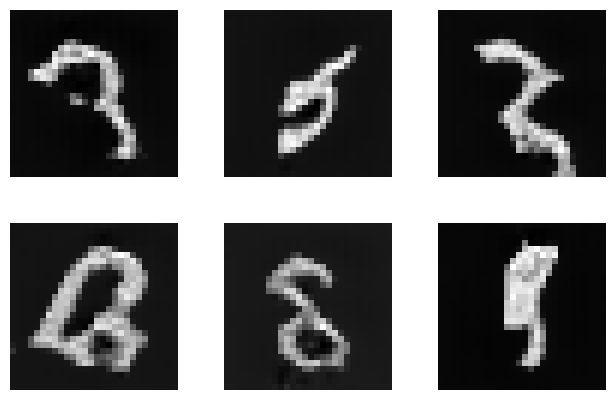

Epoch 58: 100%|██████████| 430/430 [00:05<00:00, 78.81it/s, v_num=6, g_loss=1.050, d_loss=0.605]epoch  58


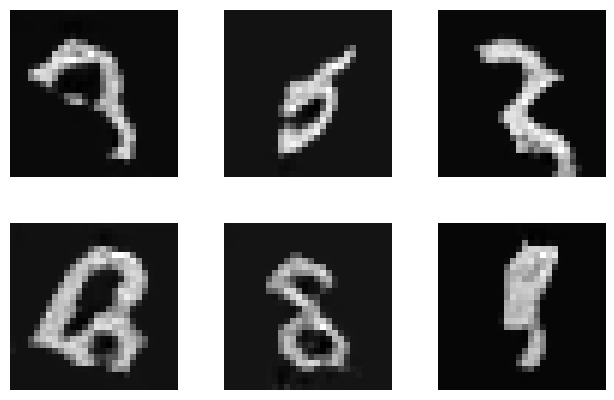

Epoch 59: 100%|██████████| 430/430 [00:05<00:00, 73.65it/s, v_num=6, g_loss=0.970, d_loss=0.533]epoch  59


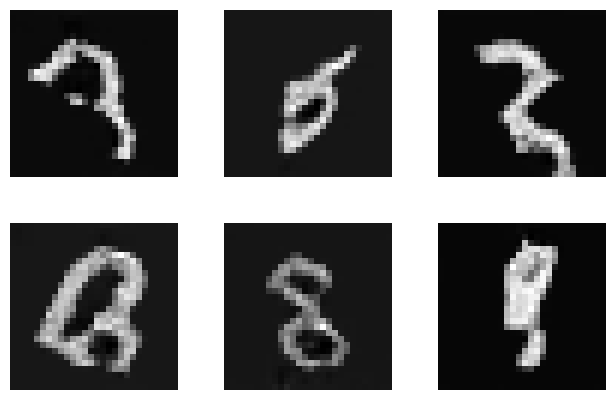

Epoch 60: 100%|██████████| 430/430 [00:05<00:00, 74.72it/s, v_num=6, g_loss=0.988, d_loss=0.666]epoch  60


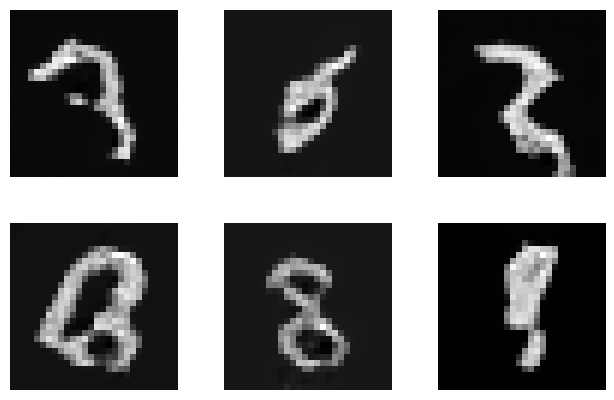

Epoch 61: 100%|██████████| 430/430 [00:05<00:00, 71.93it/s, v_num=6, g_loss=0.892, d_loss=0.620]epoch  61


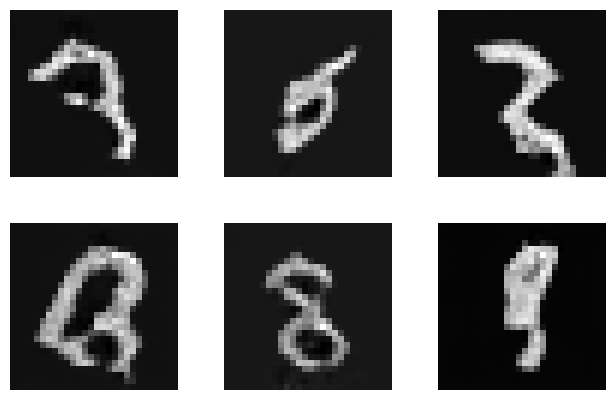

Epoch 62: 100%|██████████| 430/430 [00:05<00:00, 74.01it/s, v_num=6, g_loss=1.010, d_loss=0.610]epoch  62


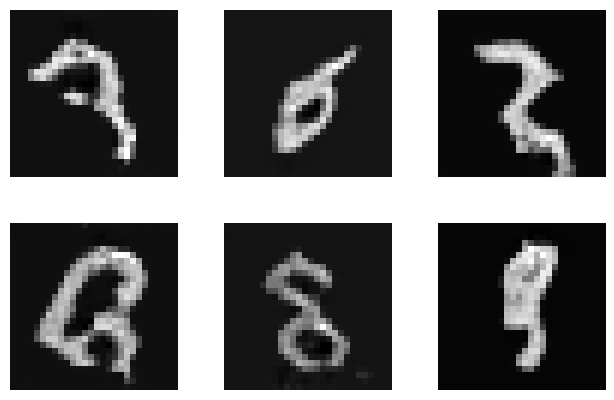

Epoch 63: 100%|██████████| 430/430 [00:05<00:00, 77.47it/s, v_num=6, g_loss=1.070, d_loss=0.608]epoch  63


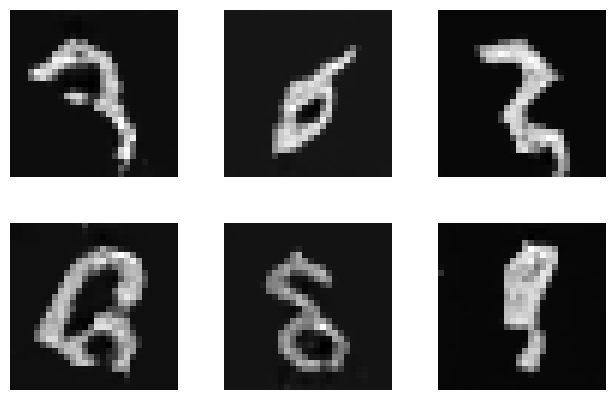

Epoch 64: 100%|██████████| 430/430 [00:05<00:00, 75.29it/s, v_num=6, g_loss=1.020, d_loss=0.583]epoch  64


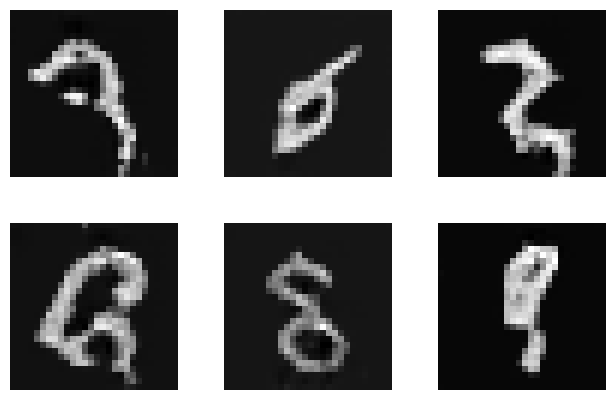

Epoch 65: 100%|██████████| 430/430 [00:05<00:00, 75.33it/s, v_num=6, g_loss=0.933, d_loss=0.526]epoch  65


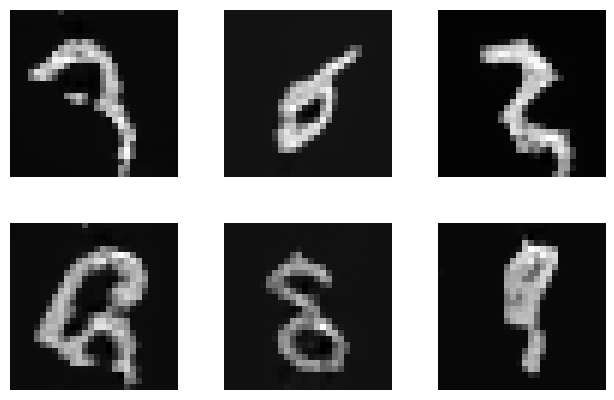

Epoch 66: 100%|██████████| 430/430 [00:06<00:00, 71.20it/s, v_num=6, g_loss=1.060, d_loss=0.600]epoch  66


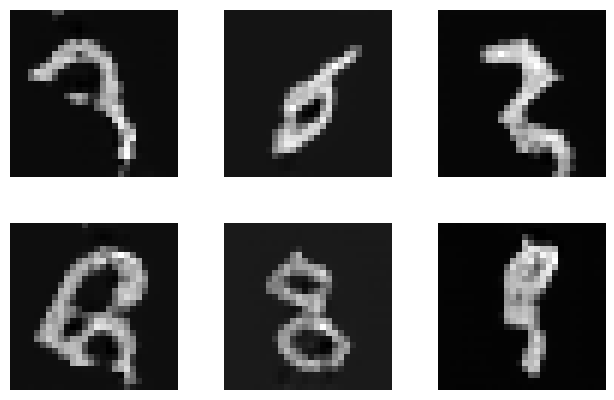

Epoch 67: 100%|██████████| 430/430 [00:06<00:00, 64.43it/s, v_num=6, g_loss=1.160, d_loss=0.509]epoch  67


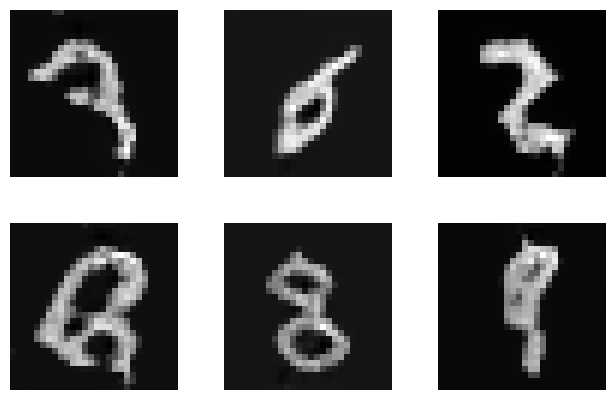

Epoch 68: 100%|██████████| 430/430 [00:06<00:00, 64.46it/s, v_num=6, g_loss=0.923, d_loss=0.595]epoch  68


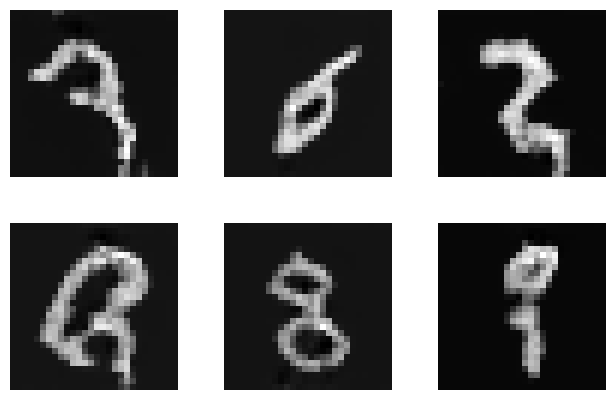

Epoch 69: 100%|██████████| 430/430 [00:06<00:00, 65.84it/s, v_num=6, g_loss=1.150, d_loss=0.610]epoch  69


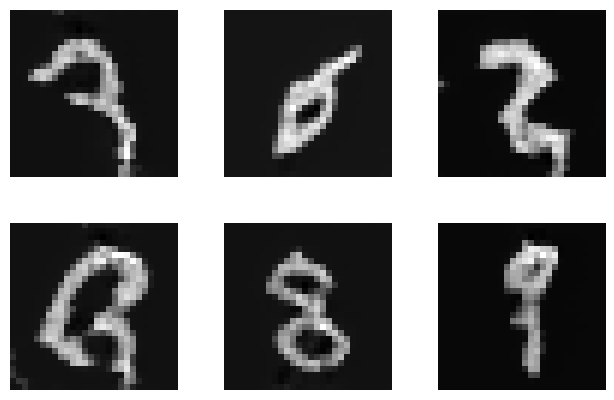

Epoch 70:  88%|████████▊ | 377/430 [00:05<00:00, 70.34it/s, v_num=6, g_loss=1.100, d_loss=0.557]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [9]:
trainer = pl.Trainer(max_epochs=100, accelerator="gpu", devices=AVAIL_GPUS)
trainer.fit(model, dm)